In [1]:
import pandas as pd
import math
from unidecode import unidecode
import numpy as np
import scipy.io
from scipy.optimize import minimize
from scipy.stats import norm
import matplotlib.pyplot as plt
import os

from scipy.stats import linregress

PATH = "./DatosExperimento1/UGR"

In [2]:
def normcdf2(x, mu, sigma):
    '''
    Utilizo la función norm.cdf de la librería scipy.stats para calcular la función de distribución acumulada (CDF) 
    de la distribución normal, y luego dividimos el resultado por dos y sumamos 0.5 para ajustar el rango a [0,1].
    '''
    y = (norm.cdf(x, mu, sigma) + 1) / 2
    return y

def normcdf2_minimizer(X, params):
    # X incluye mu y sigma
    mu = X[0]
    sigma = X[1]

    # x/y valores para ajustar
    x = params['x']
    y = params['y']

    # los valores ajustados con mu y sigma dados
    yfit = normcdf2(x, mu, sigma)

    # cálculo del error
    err = np.sum((yfit - y)**2)

    return err

In [3]:
# Variables generales
ruidos = scipy.io.loadmat('ruidosExp1.mat')
ruidos = np.array(ruidos['ruidos'])
minX = np.min(ruidos[:, 2])
maxX = np.max(ruidos[:, 2])
LoopNumber = 16
numberObservations = 10

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Wed May 24 15:40:20 2023', '__version__': '1.0', '__globals__': ['datos'], 'Results': array([[0.33333333, 4.0852902 ],
       [1.        , 1.46560641],
       [0.66666667, 1.92136413],
       [1.        , 2.31965106],
       [0.66666667, 2.3826302 ],
       [1.        , 1.87941143],
       [1.        , 2.37399937],
       [1.        , 5.97124321],
       [1.        , 3.84200177],
       [1.        , 1.35035809],
       [0.66666667, 1.92195249],
       [0.33333333, 2.27858911],
       [1.        , 1.76980817],
       [0.33333333, 2.03488874],
       [0.66666667, 1.71474862],
       [1.        , 2.93107008],
       [1.        , 6.19323676],
       [1.        , 1.34396437],
       [1.        , 3.10064596],
       [1.        , 2.0596605 ],
       [1.        , 4.61344985],
       [0.66666667, 6.04183072],
       [0.66666667, 2.45408744],
       [0.66666667, 1.91425277],
       [1.        , 2.29270497],
       [1.        , 

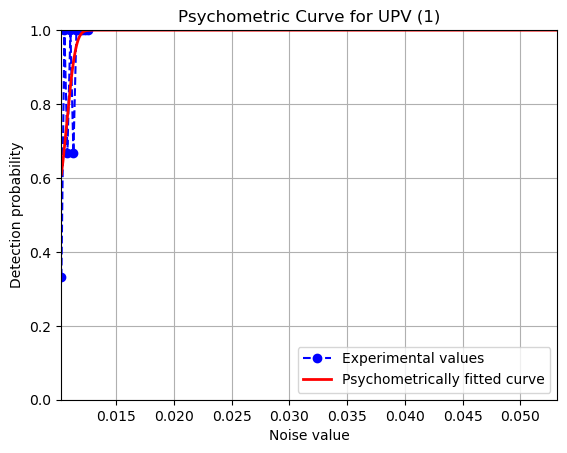

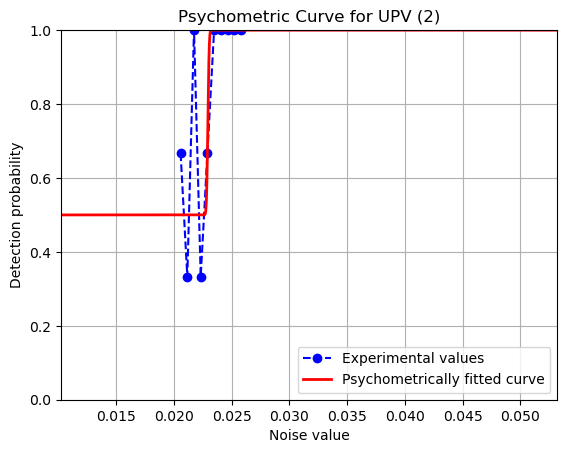

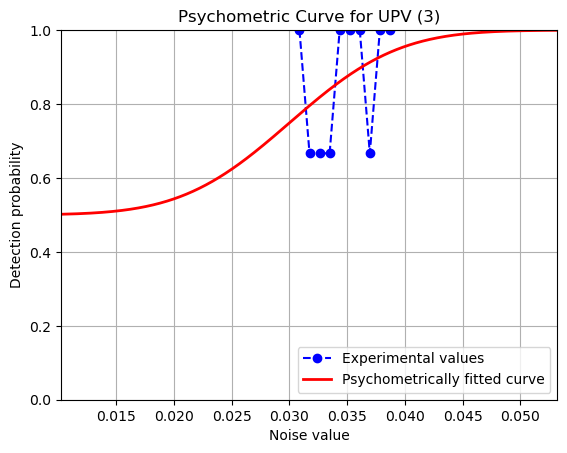

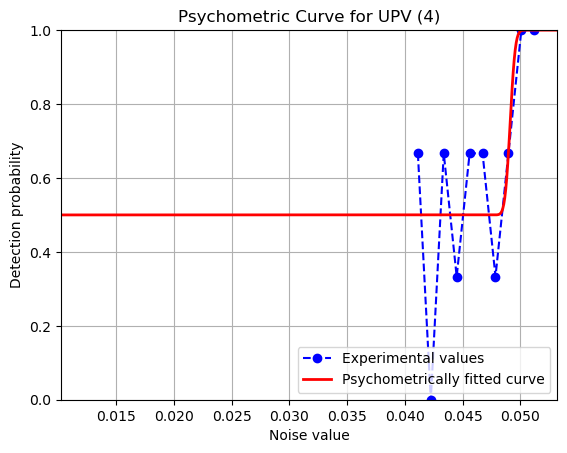

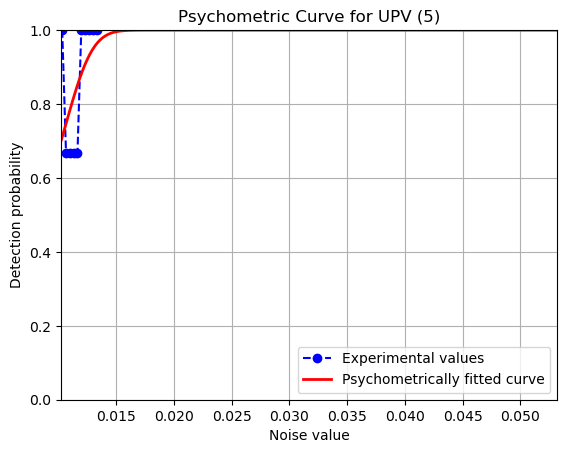

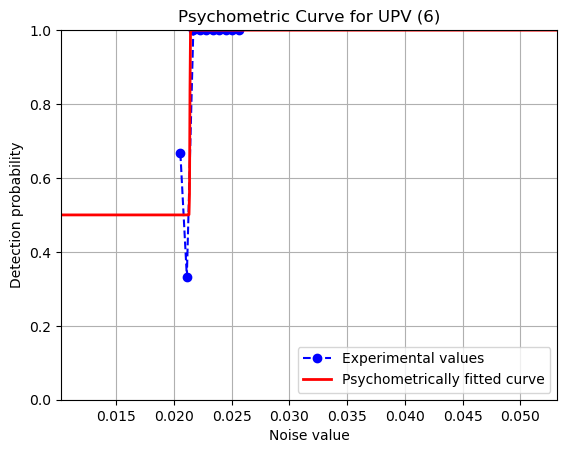

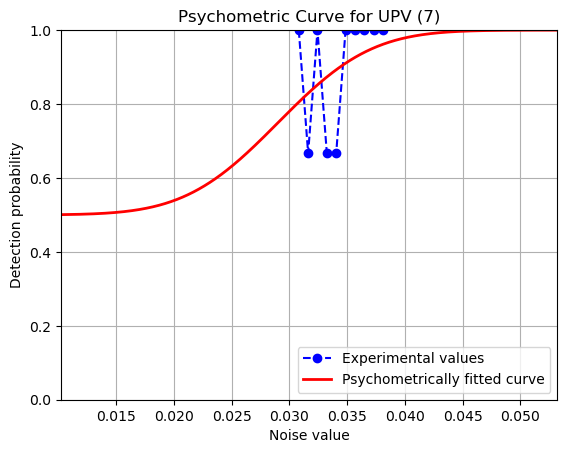

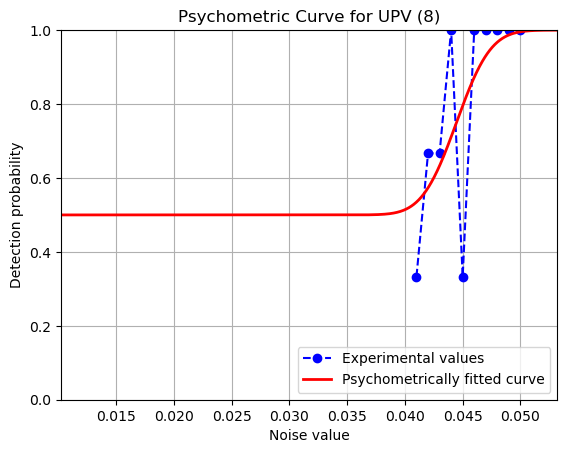

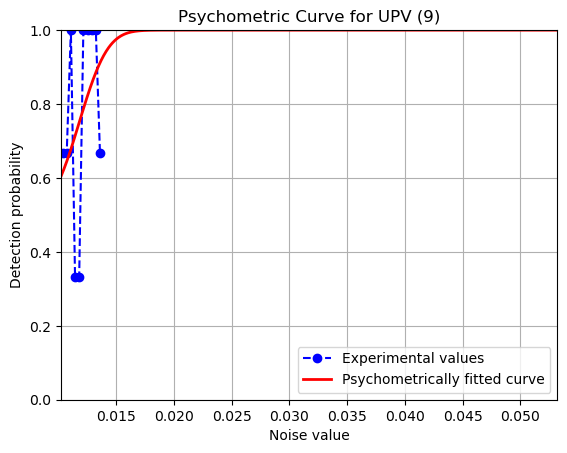

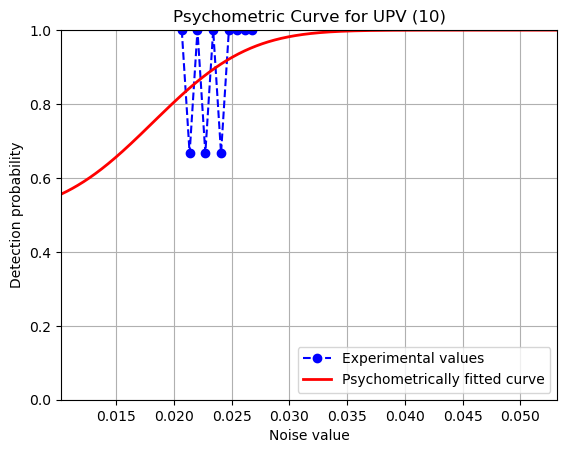

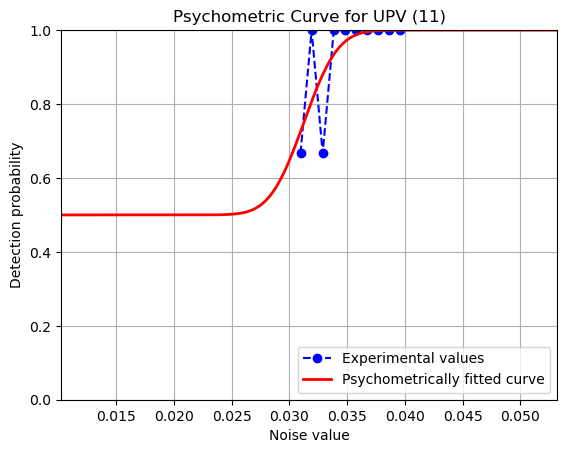

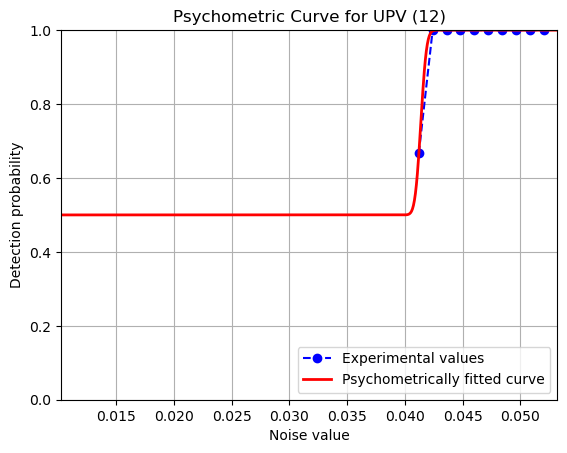

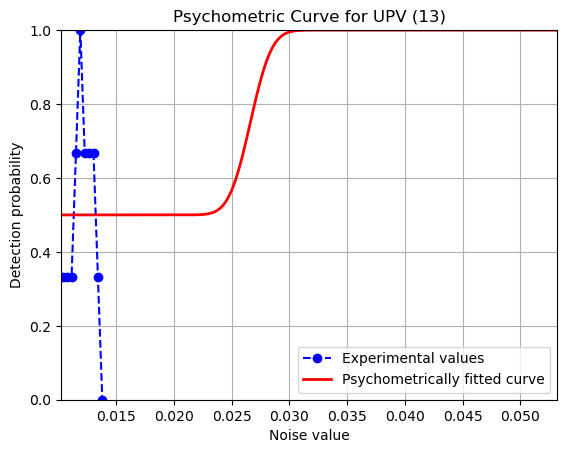

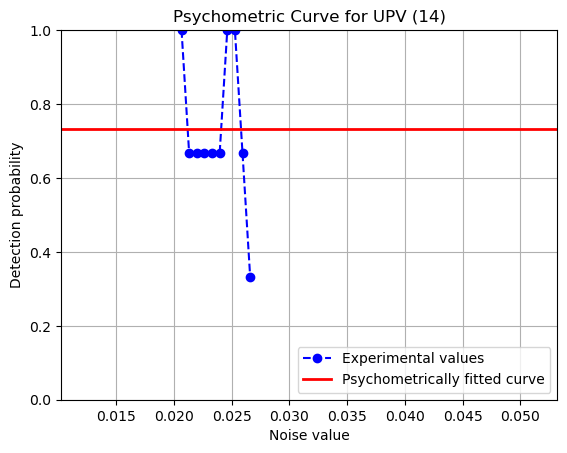

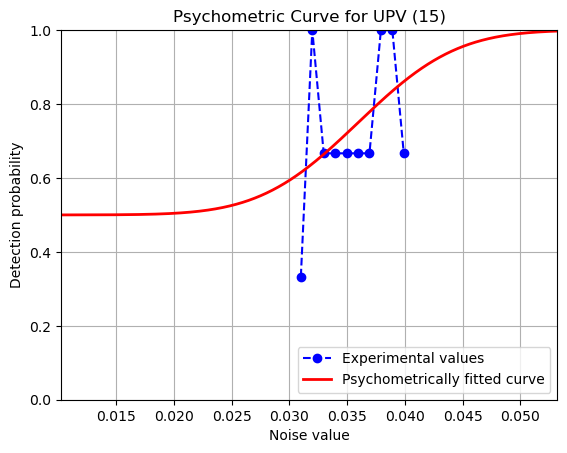

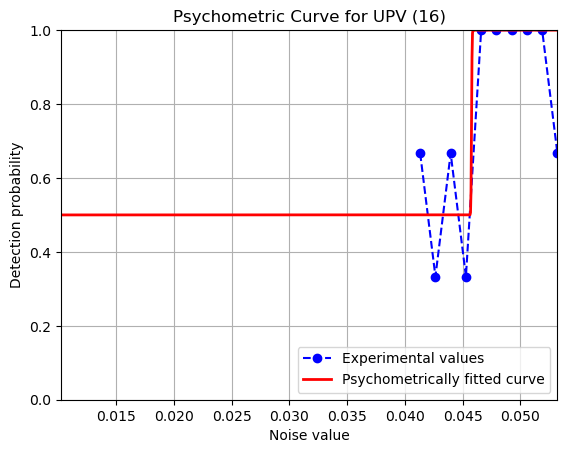

<Figure size 640x480 with 0 Axes>

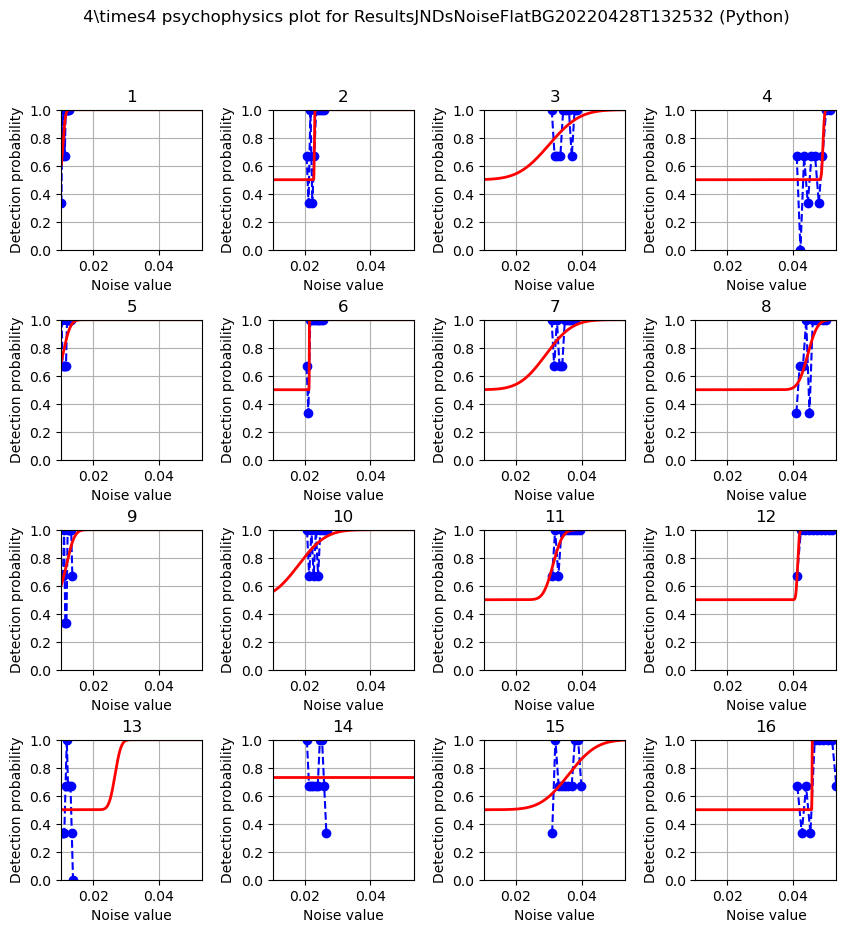

<Figure size 640x480 with 0 Axes>

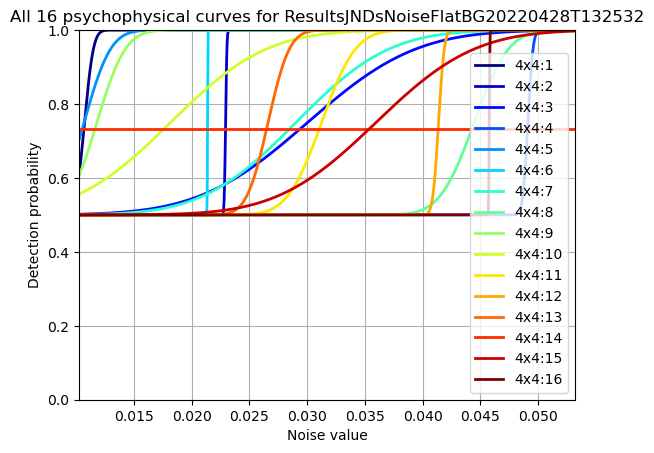

In [8]:
data_file = PATH+'/ResultsJNDsNoiseFlatBG20220428T132532.mat'
result = scipy.io.loadmat(data_file)
print(result)
result = np.array(result['Results'])
print(result)

# Individual plot
for i in range(LoopNumber):
    x = ruidos[i*numberObservations:(i+1)*numberObservations, 2]
    ruido_base = ruidos[i*numberObservations:(i+1)*numberObservations, 0][0]
    y = result[i*numberObservations:(i+1)*numberObservations, 0]

    # Valores iniciales de la minimización
    X0 = [np.mean(x), 0.1*np.mean(x)]

    # parámetros para el ajuste
    params = {'x': x, 'y': y}

    # minimización
    ParamsOpt = minimize(normcdf2_minimizer, X0, args=params, method='Nelder-Mead').x

    # media y la desviación estándar de la distribución ajustada
    # Se corresponde al umbral, ruido correspondiente a una prob de detección de 0.75
    meanAndStdDistrib = [ParamsOpt[0], ParamsOpt[1]]

    # resultados en gráficos independientes
    plt.figure(i)
    plt.plot(x, y, 'o--b')
    plt.axis([min(x), max(x), 0, 1])
    x_curve = np.linspace(minX, maxX, num=1000)
    y_curve = normcdf2(x_curve, ParamsOpt[0], ParamsOpt[1])
    plt.plot(x_curve, y_curve, '-r', linewidth=2)
    plt.title('Psychometric Curve for UPV ('+ str(i+1)+")")
    plt.xlabel('Noise value')
    plt.ylabel('Detection probability')
    plt.legend(['Experimental values', 'Psychometrically fitted curve'], loc='lower right')
    plt.grid(True)
    plt.xlim([minX, maxX])
    plt.ylim([0, 1])
    
    plt.show()

# 4 times 4 psychophysics plot

plt.figure() 
figure = plt.figure(figsize=(numberObservations, numberObservations))
figure.subplots_adjust(hspace=0.5, wspace=0.5)

for i in range(LoopNumber):
    x = ruidos[i*numberObservations:(i+1)*numberObservations, 2]
    y = result[i*numberObservations:(i+1)*numberObservations, 0]

    # Valores iniciales de la minimización
    X0 = [np.mean(x), 0.1*np.mean(x)]

    # Definir los parámetros para el ajuste
    params = {'x': x, 'y': y}

    # Realizar la minimización
    ParamsOpt = minimize(normcdf2_minimizer, X0, args=params, method='Nelder-Mead').x

    # Obtener la media y la desviación estándar de la distribución ajustada
    meanAndStdDistrib = [ParamsOpt[0], ParamsOpt[1]]

    ax = figure.add_subplot(4, 4, i+1)
    ax.plot(x, y, 'o--b')
    x_curve = np.linspace(minX, maxX, num=1000)
    y_curve = normcdf2(x_curve, ParamsOpt[0], ParamsOpt[1])
    ax.plot(x_curve, y_curve, '-r', linewidth=2)
    ax.grid(True)
    ax.set_xlim([minX, maxX])
    ax.set_ylim([0, 1])
    ax.set_title(str(i+1))
    ax.set_xlabel('Noise value')
    ax.set_ylabel('Detection probability')

figure.suptitle('4\\times4 psychophysics plot for ResultsJNDsNoiseFlatBG20220428T132532 (Python)')


# All 16 psychophysical curves

plt.figure() 
cc = plt.get_cmap('jet')(np.linspace(0, 1, 16))

fig, ax = plt.subplots()
for i in range(LoopNumber):
    x = ruidos[i*numberObservations:(i+1)*numberObservations, 2]
    y = result[i*numberObservations:(i+1)*numberObservations, 0]

    # Valores iniciales de la minimización
    X0 = [np.mean(x), 0.1*np.mean(x)]

    # Definir los parámetros para el ajuste
    params = {'x': x, 'y': y}

    # Realizar la minimización
    ParamsOpt = minimize(normcdf2_minimizer, X0, args=params, method='Nelder-Mead').x

    # Obtener la media y la desviación estándar de la distribución ajustada
    meanAndStdDistrib = [ParamsOpt[0], ParamsOpt[1]]

    x_curve = np.linspace(minX, maxX, num=1000)
    y_curve = normcdf2(x_curve, ParamsOpt[0], ParamsOpt[1])
    ax.plot(x_curve, y_curve, linewidth=2, color=cc[i])
    ax.grid(True)
    ax.set_xlim([minX, maxX])
    ax.set_ylim([0, 1])
    ax.set_xlabel('Noise value')
    ax.set_ylabel('Detection probability')

ax.set_title('All 16 psychophysical curves for ResultsJNDsNoiseFlatBG20220428T132532')

Legend = []
for i in range(16):
    Legend.append('4x4:{}'.format(i+1))

ax.legend(Legend)
